In [116]:

import os
import json
import math
import time
import pickle
import random
import urllib
import catboost

import numpy as np
import pandas as pd

from tqdm import tqdm


In [117]:

DROPBOX_PATH = 'C:\\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data'

def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

teams = load_dict(os.path.join(DROPBOX_PATH, 'IDs/teams'))
competitions = load_dict(os.path.join(DROPBOX_PATH, 'IDs/competitions'))


In [118]:

def load_schedules():
    
    normal = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/processed_schedule.csv'))
    stf = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/stf_schedule.csv'))

    normal['home_team_name'] = normal['home_team_id'].apply(lambda x: teams.get(x)['name'])
    normal['away_team_name'] = normal['away_team_id'].apply(lambda x: teams.get(x)['name'])

    stf['team_name'] = stf['team_id'].apply(lambda x: teams.get(x)['name'])
    stf['opp_team_name'] = stf['opp_team_id'].apply(lambda x: teams.get(x)['name'])
    
    normal['datetime_UTC'] = pd.to_datetime(normal['datetime_UTC'].copy())
    stf['datetime_UTC'] = pd.to_datetime(stf['datetime_UTC'].copy())

    normal['match_date_UTC'] = normal['datetime_UTC'].copy().dt.date
    stf['match_date_UTC'] = stf['datetime_UTC'].copy().dt.date
    
    normal['last_updated'] = pd.to_datetime(normal['last_updated'].copy())
    stf['last_updated'] = pd.to_datetime(stf['last_updated'].copy())
    
    normal = normal.loc[~normal['match_status'].isin(['deleted','collecting','cancelled','postponed'])].reset_index(drop=True)
    stf = stf.loc[~stf['match_status'].isin(['deleted','collecting','cancelled','postponed'])].reset_index(drop=True)
    
    return normal, stf 

schedule, stf_schedule = load_schedules()


C:\Users\Blake\AppData\Local\Temp\ipykernel_24468\93542962.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/processed_schedule.csv'))
C:\Users\Blake\AppData\Local\Temp\ipykernel_24468\93542962.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  stf = pd.read_csv(os.path.join(DROPBOX_PATH, 'schedules/stf_schedule.csv'))


In [119]:

def time_with_man_adv(temp):
    
    temp['man_adv'] = temp['team_strength'].copy() - temp['opp_strength'].copy()
    temp['twma'] = temp['man_adv'].copy() * temp['time_elapsed'].copy()
        
    return temp


def add_cols(stf):
    
    stf['state'] = np.where((stf['period']==1)&(stf['team_score']==stf['opp_score']), 'neutral_1H', np.nan)
    stf['state'] = np.where((stf['period']==1)&(stf['team_score']>stf['opp_score']), 'positive_1H', stf['state'].copy())
    stf['state'] = np.where((stf['period']==1)&(stf['team_score']<stf['opp_score']), 'negative_1H', stf['state'].copy())
    stf['state'] = np.where((stf['period']>1)&(stf['team_score']==stf['opp_score']), 'neutral_2H', stf['state'].copy())
    stf['state'] = np.where((stf['period']>1)&(stf['team_score']>stf['opp_score']), 'positive_2H', stf['state'].copy())
    stf['state'] = np.where((stf['period']>1)&(stf['team_score']<stf['opp_score']), 'negative_2H', stf['state'].copy())

    stf['timestamp'] = pd.to_datetime(stf['timestamp'])
    stf['time_elapsed'] = (stf['timestamp'].copy().diff().dt.seconds+(stf['timestamp'].copy().diff().dt.microseconds)/1e6)/60
    stf['time_elapsed'] = np.where(stf['time_elapsed']>1, 0, stf['time_elapsed'])
    stf['time_elapsed'] = np.where(stf['time_elapsed']>1, 0, stf['time_elapsed'])
    stf['time_elapsed'] = np.where(stf['time_elapsed']<0, 0, stf['time_elapsed'])
    assert(stf['time_elapsed'].sum()>30)
    stf = time_with_man_adv(stf)
    
    stf['third'] = np.where(stf['x']<=40, 1, 0)
    stf['third'] = np.where(((stf['x']>40)&(stf['x']<=80)), 2, stf['third'].copy())
    stf['third'] = np.where(stf['x']>80, 3, stf['third'].copy())
    
    ## pass completions by third
    stf['is_completed_pass'] = np.where(((stf['type_id']==30)&(~stf['outcome_id'].isin([9,74,75,76,77]))), 1, 0)
    stf['team_cp_f3'] = np.where(((stf['is_completed_pass']==1)&(stf['action_team']==1)&(stf['third']==3)), 1, 0)
    stf['opp_cp_f3'] = np.where(((stf['is_completed_pass']==1)&(stf['action_team']==0)&(stf['third']==1)), 1, 0)
    
    return stf

def stf_to_gsv(stf):
    
    xg = stf.groupby(['state','action_team']).agg({
    'shot_statsbomb_xg':'sum'
    }).reset_index().pivot(index='state', columns='action_team', values='shot_statsbomb_xg').reset_index()
    xg.columns=['state','opp_xg','team_xg']

    time_and_xxg = stf.groupby(['state']).agg({
        'time_elapsed':'sum',
        'twma':'sum',
        'cg':'sum',
        'cc':'sum'
    }).reset_index()

    field_tilt = stf.groupby(['state']).agg({
        'team_cp_f3':'sum',
        'opp_cp_f3':'sum'
    }).reset_index()

    field_tilt.columns=['state','team_cp_f3','opp_cp_f3']
    field_tilt['field_tilt'] = (field_tilt['team_cp_f3']/(field_tilt['team_cp_f3']+field_tilt['opp_cp_f3'])).fillna(0)

    output = xg.merge(time_and_xxg, how='left', on=['state']).merge(field_tilt[['state','field_tilt']], how='left', on=['state'])
    output['man_adv'] = output['twma']/output['time_elapsed']
    output = output.drop(columns=['twma'])
    
    return output

def create_gsv(row):
    
    stf = pd.read_csv(row['STF_path'])
    stf = add_cols(stf)
    gsv = stf_to_gsv(stf)
    gsv['match_id'],gsv['team_id'],gsv['opp_team_id'] = row['match_id'],row['team_id'],row['opp_team_id']
    gsv['is_home'],gsv['datetime_UTC'],gsv['manager_id'],gsv['opp_manager_id'] = row['is_home'],row['datetime_UTC'],row['manager_id'],row['opp_manager_id']

    ##standardize by time
    gsv['cg'] = gsv['cg']/gsv['time_elapsed']
    gsv['cc'] = gsv['cc']/gsv['time_elapsed']
    gsv['team_xg'] = gsv['team_xg']/gsv['time_elapsed']
    gsv['opp_xg'] = gsv['opp_xg']/gsv['time_elapsed']
    return gsv


In [120]:


def divide_into_3(df, n=3):
    
    ### not going to make dynamic for speed reasons
    if n != 3:
        raise NotImplemented
    breakpoint = len(to_add)//n
    sub_dfs = {}
#     for i in range(n):
#         if i != n-1:
#             print((breakpoint*i, breakpoint*(i+1)))
            
#         else:
#             print(breakpoint*i)
    return df[:breakpoint], df[breakpoint:breakpoint*2], df[breakpoint*2:]


def update_data(start_from_beginning=False):
    
    available = stf_schedule.copy().loc[stf_schedule['match_status']=='available'].reset_index(drop=True)
    if start_from_beginning:
        existing_ids = []
    else:
        existing = pd.read_csv(os.path.join(DROPBOX_PATH,'Statsbomb/game_states/game_state_vecs.csv'))
        existing_ids = list(existing.match_id.unique())
    to_add = available.copy().loc[~available['match_id'].isin(existing_ids)].reset_index(drop=True)
    to_add['STF_path'] = to_add.apply(lambda x: os.path.join(DROPBOX_PATH, f'Statsbomb/STF/{x.competition_id}/{x.season_id}/{x.match_id}-{x.team_id}.csv'),axis=1)
    print(f"We have {len(to_add)/2} new games we can add to game state vecs...")
#     df1, df2, df3 = divide_into_3(to_add)
#     raise ValueError()
    new_gsvs = []
    for index, row in tqdm(to_add.iterrows(), total=len(to_add)):
        if os.path.exists(row['STF_path']):
            gsv = create_gsv(row)
            new_gsvs.append(gsv)
        else:
            print(f"{row['STF_path']} does not exist")
    
    
    if len(new_gsvs) > 0:
        print("Adding new games...")
        new_gsvs = pd.concat(new_gsvs, axis=0).reset_index(drop=True)
        existing = pd.concat([existing, new_gsvs], axis=0)
        ## this should drop zero rows
        existing = existing.drop_duplicates(subset=['match_id','team_id','state']).reset_index(drop=True)
        for stat in ['opp_xg','team_xg','cg','cc']:
            existing[stat] = existing[stat].fillna(0)
        for stat in ['field_tilt']:
            existing[stat] = existing[stat].fillna(0.5)
        existing.to_csv(os.path.join(DROPBOX_PATH, 'Statsbomb/game_states/game_state_vecs.csv'), index=False)
        
    return 



In [121]:


update_data()


We have 4.0 new games we can add to game state vecs...


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 7998.67it/s]

C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822006-1868.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822006-8143.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822007-1973.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822007-8144.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822008-1973.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822008-8144.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822009-1868.csv does not exist
C:\Users\Blake\G Street Dropbox\Blake Atkinson\shared_soccer_data\data\Statsbomb/STF/104/91/3822009-8143.csv does not exist


In [128]:

### need to test weights ###



In [43]:

from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder


In [124]:
gsvs = pd.read_csv(os.path.join(DROPBOX_PATH, 'Statsbomb/game_states/game_state_vecs.csv'))

In [126]:
gsvs = gsvs.merge(schedule[['match_id','match_date_UTC']], how='left')
gsvs['match_date_UTC'] = pd.to_datetime(gsvs['match_date_UTC'])
gsvs.head()

,state,opp_xg,team_xg,time_elapsed,cg,cc,field_tilt,man_adv,match_id,team_id,opp_team_id,is_home,datetime_UTC,manager_id,opp_manager_id,match_date_UTC
0,negative_1H,0.012476,0.009200,34.709050,0.179904,0.136924,0.727273,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0,2017-07-28
1,negative_2H,0.038915,0.006169,42.339517,0.142951,0.270379,0.500000,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0,2017-07-28
2,neutral_1H,0.014894,0.014841,8.233550,0.131542,0.110744,0.636364,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0,2017-07-28
3,neutral_1H,0.014841,0.014894,8.233550,0.110744,0.131542,0.363636,0.0,9949,164,163,0,2017-07-28 19:00:00,216.0,196.0,2017-07-28
4,positive_1H,0.009200,0.012476,34.709050,0.136924,0.179904,0.263158,0.0,9949,164,163,0,2017-07-28 19:00:00,216.0,196.0,2017-07-28


In [127]:

import gc
gc.collect()

6364

In [94]:

stat = 'cg'
state = 'positive_2H'

X = gsvs.loc[gsvs['time_elapsed']>0.5].reset_index(drop=True).copy()[['datetime_UTC','state','team_id','opp_team_id','time_elapsed','is_home','man_adv',stat]]
X = X.loc[X['state']==state].reset_index(drop=True)
X['days_ago'] = (datetime.now()-X['datetime_UTC']).apply(lambda x: x.days + x.seconds/(24*60*60))
X['weight'] = np.exp((-1/300)*X['days_ago'])
X['weight_2'] = X['time_elapsed'].copy()/45
X['weight'] = X['weight'].copy()*X['weight_2'].copy()
X = X.loc[X['weight']>0.01].reset_index(drop=True)

team_ohe = OneHotEncoder()
opp_ohe = OneHotEncoder()

team_X = team_ohe.fit_transform(X.team_id.values.reshape(-1,1)).toarray()
opp_X = opp_ohe.fit_transform(X.opp_team_id.values.reshape(-1,1)).toarray()
y = X[stat].values.reshape(-1,1)
weights = X['weight'].values
X = np.concatenate([team_X, opp_X, X[['is_home','man_adv']].values], axis=1)
print("X concatenated")

reg = Ridge()
reg.fit(X, y, sample_weight=weights)
pos_teams = team_ohe.categories_
pos_coefs = reg.coef_[0]



X concatenated


In [95]:

stat = 'cg'
state = 'neutral_2H'

X = gsvs.loc[gsvs['time_elapsed']>0.5].reset_index(drop=True).copy()[['datetime_UTC','state','team_id','opp_team_id','time_elapsed','is_home','man_adv',stat]]
X = X.loc[X['state']==state].reset_index(drop=True)
X['days_ago'] = (datetime.now()-X['datetime_UTC']).apply(lambda x: x.days + x.seconds/(24*60*60))
X['weight'] = np.exp((-1/300)*X['days_ago'])
X['weight_2'] = X['time_elapsed'].copy()/45
X['weight'] = X['weight'].copy()*X['weight_2'].copy()
X = X.loc[X['weight']>0.01].reset_index(drop=True)

team_ohe = OneHotEncoder()
opp_ohe = OneHotEncoder()

team_X = team_ohe.fit_transform(X.team_id.values.reshape(-1,1)).toarray()
opp_X = opp_ohe.fit_transform(X.opp_team_id.values.reshape(-1,1)).toarray()
y = X[stat].values.reshape(-1,1)
weights = X['weight'].values
X = np.concatenate([team_X, opp_X, X[['is_home','man_adv']].values], axis=1)
print("X concatenated")

reg = Ridge()
reg.fit(X, y, sample_weight=weights)
neu_teams = team_ohe.categories_
neu_coefs = reg.coef_[0]


X concatenated


In [96]:

pos = pd.DataFrame({
    'team_id':pos_teams[0],
    'pos_ratings':pos_coefs[:len(pos_teams[0])]
})

neu = pd.DataFrame({
    'team_id':neu_teams[0],
    'neu_ratings':neu_coefs[:len(neu_teams[0])]
})

data = pd.merge(pos, neu, how='left')



In [105]:
teams[937]

{'name': 'Barcelona WFC',
 'gender': 'female',
 'youth': False,
 'group': None,
 'country_id': 214,
 'country_name': 'Spain'}

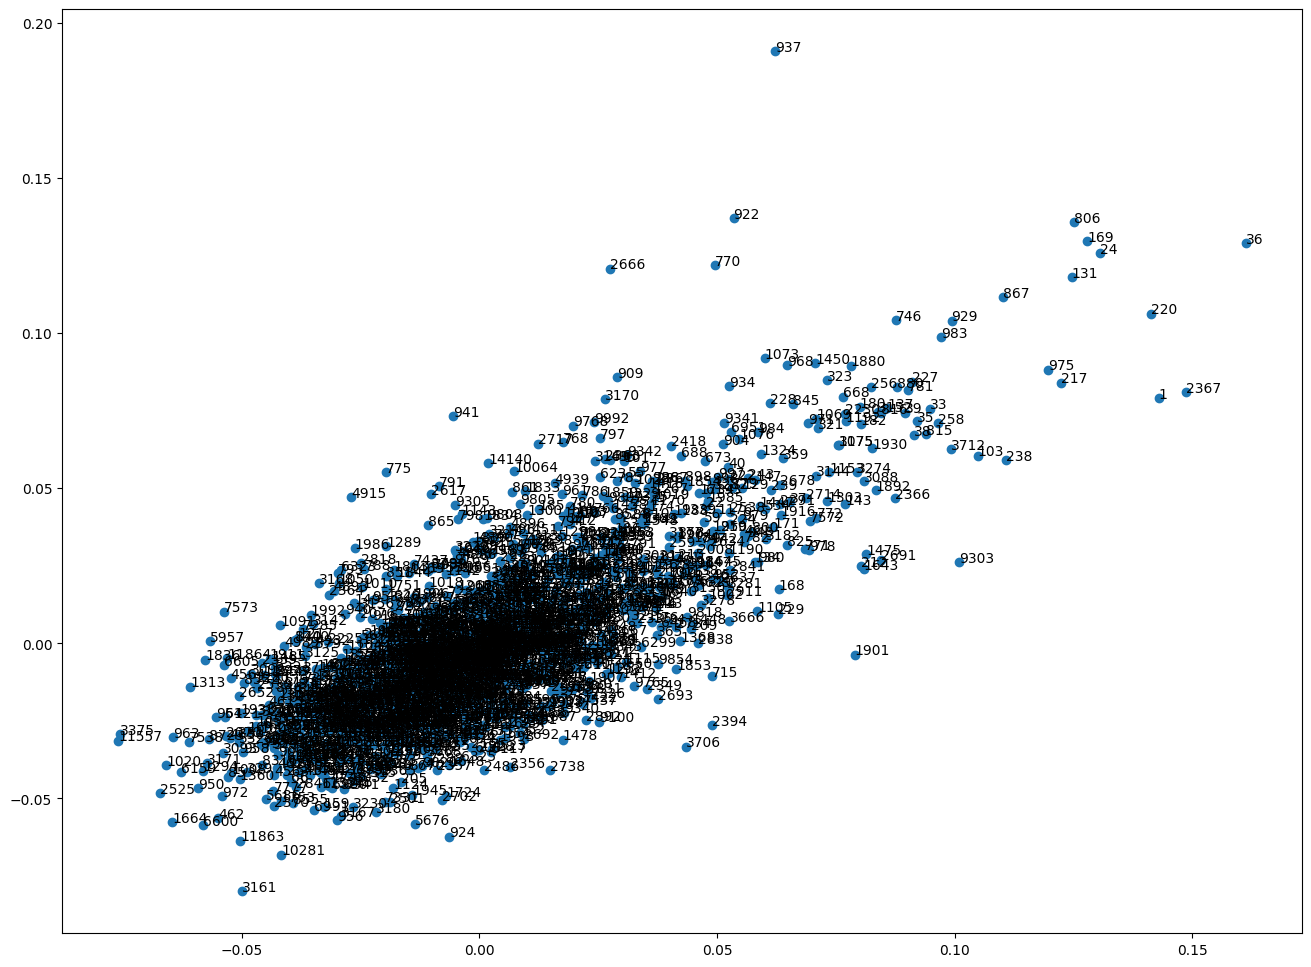

In [104]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(data.neu_ratings, data.pos_ratings, label=data.team_id)
n = data.team_id.values
for i, txt in enumerate(n):
    ax.annotate(txt, (data['neu_ratings'][i], data['pos_ratings'][i]))
plt.show()


In [84]:
len(pos_teams[0])
len(pos_coefs)

3592

0.05583677652154605

In [31]:

# gsvs = pd.concat(gsvs, axis=0).reset_index(drop=True)
# gsvs.to_csv(os.path.join(DROPBOX_PATH, 'Statsbomb/game_states/game_state_vecs.csv'), index=False)


In [57]:
gsvs

,state,opp_xg,team_xg,time_elapsed,cg,cc,field_tilt,man_adv,match_id,team_id,opp_team_id,is_home,datetime_UTC,manager_id,opp_manager_id
0,negative_1H,0.012476,0.009200,34.709050,0.179904,0.136924,0.727273,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0
1,negative_2H,0.038915,0.006169,42.339517,0.142951,0.270379,0.500000,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0
2,neutral_1H,0.014894,0.014841,8.233550,0.131542,0.110744,0.636364,0.0,9949,163,164,1,2017-07-28 19:00:00,196.0,216.0
3,neutral_1H,0.014841,0.014894,8.233550,0.110744,0.131542,0.363636,0.0,9949,164,163,0,2017-07-28 19:00:00,216.0,196.0
4,positive_1H,0.009200,0.012476,34.709050,0.136924,0.179904,0.263158,0.0,9949,164,163,0,2017-07-28 19:00:00,216.0,196.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424175,positive_2H,0.019815,0.030798,37.896417,0.164826,0.268813,0.303797,0.0,3844707,44,84,0,2023-02-28 21:00:00,259.0,1000137.0
424176,negative_1H,0.000853,0.006714,43.129283,0.220894,0.067693,0.875000,0.0,3844707,84,44,1,2023-02-28 21:00:00,1000137.0,259.0
424177,negative_2H,0.030798,0.019815,37.896417,0.268813,0.164826,0.696203,0.0,3844707,84,44,1,2023-02-28 21:00:00,1000137.0,259.0
424178,neutral_1H,0.030385,0.000000,3.051283,0.034784,0.162602,0.000000,0.0,3844707,84,44,1,2023-02-28 21:00:00,1000137.0,259.0


In [85]:
existing.loc[existing['pct_man_adv']>0]

,datetime_UTC,match_id,competition_id,team_id,opp_team_id,manager_id,opp_manager_id,is_home,time_in_state,pct_man_adv,team_xG,opp_xG,xxG_for,xxG_against,field_tilt,game_state
64,2017-08-04 19:00:00,9960,8,158,153,215.0,213.0,1,44.120521,1.000000,0.008416,0.001923,0.175663,0.115164,0.372952,positive_2H
79,2017-08-04 19:00:00,9960,8,158,153,215.0,213.0,1,35.738314,0.029964,0.017525,0.002134,0.116429,0.164411,0.278025,positive_1H
91,2017-08-04 19:00:00,9964,8,164,167,216.0,197.0,1,14.569869,1.276325,0.036543,0.000000,0.325951,0.035545,0.964689,neutral_2H
92,2017-08-04 19:00:00,9964,8,164,167,216.0,197.0,1,6.060047,2.000000,0.126973,0.000000,0.305997,0.025606,1.000000,positive_2H
94,2017-08-04 19:00:00,9964,8,164,167,216.0,197.0,1,20.929422,0.458961,0.009336,0.000000,0.210746,0.062014,0.791484,negative_2H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383650,2023-02-26 21:00:00,3851667,11,422,213,1592.0,637.0,0,35.594457,0.027893,0.004877,0.031424,0.085431,0.326618,0.158408,positive_2H
383652,2023-02-26 21:30:00,3854543,13,1364,256,1002541.0,34.0,0,60.020293,1.845619,0.004362,0.007208,0.119081,0.136770,0.730594,positive_2H
383653,2023-02-26 21:30:00,3854543,13,1364,256,1002541.0,34.0,0,15.460599,0.411524,0.061590,0.022276,0.352236,0.136732,0.645238,neutral_1H
383684,2023-02-27 02:05:00,3870453,73,1226,1299,1002591.0,1001172.0,0,13.499944,0.454249,0.005668,0.059857,0.169285,0.275289,0.878697,negative_1H


In [78]:

row = to_add.iloc[0]
game_stf = pd.read_csv(row['STF_path'])


In [130]:

stf = game_stf.copy()



In [139]:

### just column ordering
gsv 


,state,opp_xg,team_xg,time_elapsed,cg,cc,field_tilt,man_adv,match_id,team_id,opp_team_id,is_home,datetime_UTC,manager_id,opp_manager_id
0,negative_1H,0.003851,0.521932,36.077400,7.489733,1.521328,0.892857,0.0,3863796,7288,7290,1,2023-02-16 15:00:00,1002217.0,1002212.0
1,negative_2H,0.159840,0.409503,25.392633,4.744078,2.809779,0.666667,0.0,3863796,7288,7290,1,2023-02-16 15:00:00,1002217.0,1002212.0
2,neutral_1H,0.240762,0.000000,9.354367,0.688638,2.178805,0.100000,0.0,3863796,7288,7290,1,2023-02-16 15:00:00,1002217.0,1002212.0
3,neutral_2H,0.905157,0.137122,21.698500,2.946141,3.625266,0.769231,0.0,3863796,7288,7290,1,2023-02-16 15:00:00,1002217.0,1002212.0


In [132]:

existing


,datetime_UTC,match_id,competition_id,team_id,opp_team_id,manager_id,opp_manager_id,is_home,time_in_state,pct_man_adv,team_xG,opp_xG,xxG_for,xxG_against,field_tilt,game_state
0,2017-07-28 19:00:00,9949,8,163,164,196.0,216.0,1,10.052229,0.0,0.012156,0.012199,0.107743,0.090708,0.534909,neutral_1H
1,2017-07-28 19:00:00,9949,8,163,164,196.0,216.0,1,48.741429,0.0,0.005359,0.033804,0.124175,0.234866,0.485561,negative_2H
2,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,10.052229,0.0,0.012199,0.012156,0.090708,0.107743,0.465091,neutral_1H
3,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,36.738229,0.0,0.011787,0.008692,0.129362,0.169967,0.316158,positive_1H
4,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,48.741429,0.0,0.033804,0.005359,0.234866,0.124175,0.477909,positive_2H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383694,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,58.284372,0.0,0.013931,0.002698,0.190075,0.094916,0.623246,negative_2H
383695,2023-02-27 04:05:00,3870454,73,1311,1298,3012.0,2947.0,1,16.833362,0.0,0.059531,0.003299,0.275178,0.167547,0.463341,positive_1H
383696,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,24.990388,0.0,0.005061,0.008703,0.144865,0.133847,0.551581,neutral_1H
383697,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,16.833362,0.0,0.003299,0.059531,0.167547,0.275178,0.521488,negative_1H


,state,opp_xg,team_xg,time_elapsed,twma,cg,cc,field_tilt
0,negative_1H,0.003851,0.521932,36.077400,0.0,7.489733,1.521328,0.892857
1,negative_2H,0.159840,0.409503,25.392633,0.0,4.744078,2.809779,0.666667
2,neutral_1H,0.240762,0.000000,9.354367,0.0,0.688638,2.178805,0.100000
3,neutral_2H,0.905157,0.137122,21.698500,0.0,2.946141,3.625266,0.769231


In [106]:
game = stf.copy()








,team_cp_f3,opp_cp_f3
state,,
negative_1H,25,3
negative_2H,24,12
neutral_1H,1,9
neutral_2H,10,3


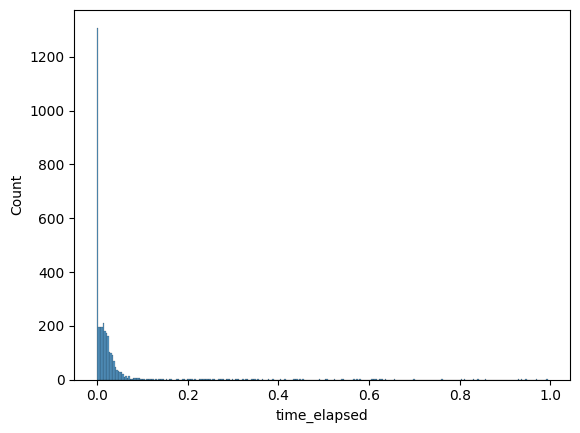

In [91]:


sns.histplot(stf['time_elapsed'])
plt.show()


In [66]:
import seaborn as sns
# sns.displot(stf['timestamp'].diff())

# 

0            NaN
1       0.000000
2       0.003050
3       0.021533
4       0.000000
          ...   
3391    0.000000
3392    0.269933
3393    0.034400
3394    0.006967
3395    0.000000
Name: timestamp, Length: 3396, dtype: float64

In [35]:

stf[['team_score','opp_score']]

np.where()



,team_score,opp_score
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3391,1,2
3392,1,2
3393,1,2
3394,1,2


In [24]:

stf = game_stf.copy()
to_add

,match_id,score,opp_score,attendance,behind_closed_doors,neutral_ground,play_status,match_status,match_status_360,last_updated,...,total,competition_game_number,is_home,team_game_number,season_number,is_keep,team_name,opp_team_name,match_date_UTC,STF_path
0,3863796,1.0,2.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 15:17:52.519154,...,3.0,101,1,19,1,0,Goa,Chennaiyin,2023-02-16,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
1,3863796,2.0,1.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 15:17:52.519154,...,3.0,101,0,19,1,0,Chennaiyin,Goa,2023-02-16,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
2,3854946,2.0,2.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 12:37:01.360957,...,4.0,111,0,22,1,0,Standard Liège II,KRC Genk II,2023-02-19,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
3,3854946,2.0,2.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 12:37:01.360957,...,4.0,111,1,22,1,0,KRC Genk II,Standard Liège II,2023-02-19,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
4,3846450,2.0,1.0,NaN,False,False,Normal,available,unscheduled,2023-02-28 17:51:02.776802,...,3.0,45,1,134,1,0,Hamilton Academical,Inverness CT,2023-02-21,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,3852042,2.0,4.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 05:26:07.970210,...,6.0,1548,0,218,6,1,Torino,Juventus,2023-02-28,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
326,3861507,3.0,1.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 06:29:31.842220,...,4.0,71,0,263,1,0,Oldham Athletic,Barnet,2023-02-28,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
327,3861507,1.0,3.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 06:29:31.842220,...,4.0,71,1,34,1,0,Barnet,Oldham Athletic,2023-02-28,C:\Users\Blake\G Street Dropbox\Blake Atkinson...
328,3844707,2.0,2.0,NaN,False,False,Normal,available,unscheduled,2023-03-01 07:21:20.131637,...,4.0,879,0,219,5,1,Millwall,Luton Town,2023-02-28,C:\Users\Blake\G Street Dropbox\Blake Atkinson...


In [26]:
existing

,datetime_UTC,match_id,competition_id,team_id,opp_team_id,manager_id,opp_manager_id,is_home,time_in_state,pct_man_adv,team_xG,opp_xG,xxG_for,xxG_against,field_tilt,game_state
0,2017-07-28 19:00:00,9949,8,163,164,196.0,216.0,1,10.052229,0.0,0.012156,0.012199,0.107743,0.090708,0.534909,neutral_1H
1,2017-07-28 19:00:00,9949,8,163,164,196.0,216.0,1,48.741429,0.0,0.005359,0.033804,0.124175,0.234866,0.485561,negative_2H
2,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,10.052229,0.0,0.012199,0.012156,0.090708,0.107743,0.465091,neutral_1H
3,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,36.738229,0.0,0.011787,0.008692,0.129362,0.169967,0.316158,positive_1H
4,2017-07-28 19:00:00,9949,8,164,163,216.0,196.0,0,48.741429,0.0,0.033804,0.005359,0.234866,0.124175,0.477909,positive_2H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383694,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,58.284372,0.0,0.013931,0.002698,0.190075,0.094916,0.623246,negative_2H
383695,2023-02-27 04:05:00,3870454,73,1311,1298,3012.0,2947.0,1,16.833362,0.0,0.059531,0.003299,0.275178,0.167547,0.463341,positive_1H
383696,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,24.990388,0.0,0.005061,0.008703,0.144865,0.133847,0.551581,neutral_1H
383697,2023-02-27 04:05:00,3870454,73,1298,1311,2947.0,3012.0,0,16.833362,0.0,0.003299,0.059531,0.167547,0.275178,0.521488,negative_1H


In [25]:
current_gsvs

,match_id,team_id,opp_team_id,is_home,neutral_1H_xxG_for,opp_neutral_1H_xxG_for,neutral_2H_xxG_for,opp_neutral_2H_xxG_for,negative_1H_xxG_for,opp_negative_1H_xxG_for,...,neutral_2H_field_tilt,opp_neutral_2H_field_tilt,negative_1H_field_tilt,opp_negative_1H_field_tilt,negative_2H_field_tilt,opp_negative_2H_field_tilt,positive_1H_field_tilt,opp_positive_1H_field_tilt,positive_2H_field_tilt,opp_positive_2H_field_tilt
0,1997,26,38,1,-0.043060,-0.039523,-0.043951,-0.042144,-0.020580,-0.042748,...,-0.131674,-0.171732,-0.071785,-0.122279,-0.083458,-0.135530,-0.060871,-0.118316,-0.119299,-0.186441
1,1997,38,26,0,0.035855,0.013121,0.079006,0.041873,0.045816,0.018165,...,0.183867,0.136235,0.134529,0.066067,0.202833,0.124558,0.129794,0.079622,0.142963,0.086700
2,2232,25,31,1,0.004358,0.003121,-0.005627,0.029390,-0.011417,0.019947,...,0.011699,0.086232,-0.002653,-0.036224,-0.008621,0.023432,-0.018014,0.091614,-0.002952,0.034334
3,2232,31,25,0,0.006358,0.022460,0.028266,0.006005,0.016183,-0.010313,...,-0.079579,-0.006652,-0.084026,0.024773,-0.028322,0.009930,0.048546,0.005885,-0.021938,0.011343
4,2258,27,40,0,-0.033046,0.019558,-0.042481,0.030655,-0.000579,0.067092,...,-0.114207,0.091672,-0.049529,0.109073,-0.058694,0.086822,-0.164965,0.070142,-0.135059,0.066096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125593,3874381,15839,1978,1,-0.016733,-0.005442,-0.020261,0.002475,0.009854,-0.000639,...,-0.059883,-0.026831,0.023687,-0.034194,-0.104413,0.026808,NaN,-0.006501,NaN,-0.059966
125594,3872517,1245,1260,1,0.000520,0.014799,0.018144,0.009923,0.037521,0.015282,...,0.082204,0.002694,0.099990,0.079522,0.111645,-0.012738,0.126937,0.029339,0.067030,0.000252
125595,3872517,1260,1245,0,-0.020198,-0.013597,-0.024576,-0.032157,0.005030,-0.037134,...,-0.038122,-0.091791,-0.031943,-0.132697,0.004689,-0.075728,-0.077076,-0.101488,-0.014165,-0.115232
125596,3872795,1321,1346,0,0.015022,-0.033214,0.002551,-0.028794,0.018196,-0.013219,...,0.008603,-0.151369,0.012416,-0.150658,0.019820,-0.163723,-0.077783,-0.134221,-0.060980,-0.137309


In [5]:

current_gsvs = pd.read_csv(os.path.join(DROPBOX_PATH, 'model_ready/game_state_vecs.csv'))


In [19]:
os.listdir(os.path.join(DROPBOX_PATH,'Statsbomb'))

['atomic_sparse',
 'game_grades',
 'game_states',
 'game_vecs',
 'raw',
 'ref_data',
 'STF']

In [12]:

os.listdir(os.path.join(DROPBOX_PATH,'Statsbomb/game_states'))



['game_state_vecs.csv',
 'game_state_vec_1.csv',
 'game_state_vec_2.csv',
 'game_state_vec_3.csv',
 'game_state_vec_4.csv']